In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import DateFormatter,\
             HourLocator, MinuteLocator
%matplotlib inline

In [2]:
def convert_to_datetime(row):
    return datetime.datetime(2013, 6, 22, int(row["hour"]),\
                             int(row["minute"]), int(row["second"]) )

# Read the ExB drift and sc potential data
exbFile = "../data/SAIS_SAPS_withdata/selected_SAPS/" +\
            "A_130622/SAPS_data_ExB_iono_A_2013062205000700.txt"
scPotFile = "../data/SAIS_SAPS_withdata/selected_SAPS/" +\
            "A_130622/SAPS_data_SCPOT_A_2013062205000700.txt"
exbColNames = [ "dec_hour", "radial_vel", "azim_vel" ]
scPotColNames = [ "dec_hour", "sc_potential" ]
exbRbspDF = pandas.read_csv(exbFile, delim_whitespace=True,\
                            header=None, names=exbColNames)
scPotRbspDF = pandas.read_csv(scPotFile, delim_whitespace=True,\
                            header=None, names=scPotColNames)
# Add a datetime field from the dec_hour field
scPotRbspDF["hour"] = [ int(x) for x in scPotRbspDF["dec_hour"] ]
scPotRbspDF["minute"] = [ int( ( x - int(x) ) * 60. ) for x in scPotRbspDF["dec_hour"] ]
scPotRbspDF["second"] = [ ( x - int(x) ) for x in scPotRbspDF["dec_hour"] ]
scPotRbspDF["second"] = [ ( x * 60. )  for x in scPotRbspDF["second"] ]
scPotRbspDF["second"] = [ int( (x - int(x))*60 )  for x in scPotRbspDF["second"] ]
# The same for exb vels
exbRbspDF["hour"] = [ int(x) for x in exbRbspDF["dec_hour"] ]
exbRbspDF["minute"] = [ int( ( x - int(x) ) * 60. ) for x in exbRbspDF["dec_hour"] ]
exbRbspDF["second"] = [ ( x - int(x) ) for x in exbRbspDF["dec_hour"] ]
exbRbspDF["second"] = [ ( x * 60. )  for x in exbRbspDF["second"] ]
exbRbspDF["second"] = [ int( (x - int(x))*60 )  for x in exbRbspDF["second"] ]

# scPotRbspDF["date"] = [ datetime.datetime(2013,6,22,int(x)) for x in scPotRbspDF["dec_hour"] ]

scPotRbspDF["date"] = scPotRbspDF.apply( convert_to_datetime, axis=1 )
exbRbspDF["date"] = exbRbspDF.apply( convert_to_datetime, axis=1 )

exbRbspDF.head()

,dec_hour,radial_vel,azim_vel,hour,minute,second,date
0,5.00250,-141.478,67.5061,5,0,9,2013-06-22 05:00:09
1,5.00558,-382.432,353.5000,5,0,20,2013-06-22 05:00:20
2,5.00867,-55.779,109.4990,5,0,31,2013-06-22 05:00:31
3,5.01175,257.017,42.8934,5,0,42,2013-06-22 05:00:42
4,5.01483,-138.495,-634.3750,5,0,53,2013-06-22 05:00:53


In [3]:
# get the sd footprint velocities
sdFpVelFile = "../data/fitVelDataFpRbsp-20130622.txt"
sdFpDF = pandas.read_csv(sdFpVelFile, delim_whitespace=True,\
                             infer_datetime_format=True, parse_dates=["eventTime"])
# For now we'll only use satA
sdFpDFSatA = sdFpDF[ (sdFpDF["sat"] == "satA") \
                    & (sdFpDF["estVelMagn"] <= 1000.)\
                   ].reset_index(drop=True)
sdFpDFSatA.head()

,estVelAzim,estVelMagn,eventTime,losVelAzim,losVelMagn,rbspLocMlat,rbspLocMlt,sat
0,-79.47,485.431811,2013-06-22 05:08:00,20.7,85.7124,61.8567,22.7056,satA
1,-82.49,299.167838,2013-06-22 05:10:00,20.7,68.2644,61.7380,22.7345,satA
2,-82.68,340.266494,2013-06-22 05:12:00,20.7,78.7405,61.6264,22.7709,satA
3,-79.76,645.365022,2013-06-22 05:18:00,20.7,117.1654,61.2881,22.8645,satA
4,-82.29,573.900841,2013-06-22 05:22:00,20.7,129.0020,60.9976,22.9343,satA


In [4]:
# Format rbsp vels, averaging over the minute etc
exbRbspDF["vel_magn"] = numpy.sqrt( \
                            numpy.square(exbRbspDF["radial_vel"])\
                            + numpy.square(exbRbspDF["azim_vel"]) )
exbRbspDF["azim"] = numpy.rad2deg( \
                        numpy.arctan( \
                        exbRbspDF["azim_vel"]/exbRbspDF["radial_vel"] ) )
# Now filter only those values which are relavant
# i.e., vel angles/azims lie between -60 and -120
exbRbspDF = exbRbspDF[\
            ( exbRbspDF["azim"] >= -120. ) &\
            ( exbRbspDF["azim"] <= -60. ) ]
# Now groupby hour and minute to average the velocities over minute
exbRbspMeanVals = exbRbspDF.groupby( ["hour","minute"] ).mean().reset_index()
exbRbspMeanVals["date"] = exbRbspMeanVals.apply( lambda row: \
                                                datetime.datetime( \
                                                2013, 6, 22, row['hour'].astype(int), row['minute'].astype(int) )\
                                                , axis=1 )
exbRbspDF.head()

,dec_hour,radial_vel,azim_vel,hour,minute,second,date,vel_magn,azim
2,5.00867,-55.7790,109.499,5,0,31,2013-06-22 05:00:31,122.887460,-63.005620
8,5.02717,-76.3784,708.966,5,1,37,2013-06-22 05:01:37,713.068334,-83.851120
9,5.03022,-312.2680,789.594,5,1,48,2013-06-22 05:01:48,849.099516,-68.422234
10,5.03331,-421.2560,1011.530,5,1,59,2013-06-22 05:01:59,1095.741556,-67.390504
11,5.03639,-174.3110,468.879,5,2,11,2013-06-22 05:02:11,500.231788,-69.606821


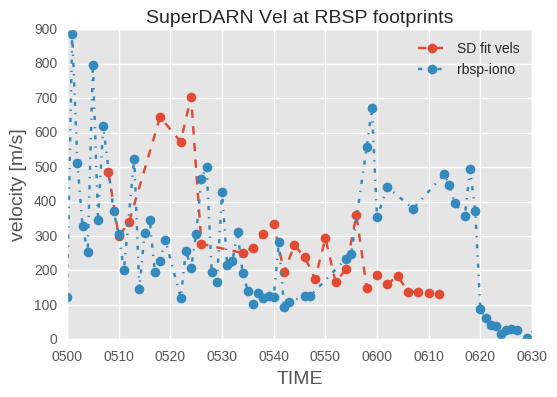

In [5]:
plt.style.use('ggplot')
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.plot_date( x=sdFpDFSatA["eventTime"], y=sdFpDFSatA["estVelMagn"], linestyle="--", label="SD fit vels" )
# ax.plot_date( x=exbRbspDF["date"], y=exbRbspDF["azim_vel"], linestyle="-", label="rbsp-iono" )
ax.plot_date( x=exbRbspMeanVals["date"], y=exbRbspMeanVals["vel_magn"], linestyle="-.", label="rbsp-iono" )
ax.set_ylabel( "velocity [m/s]", fontsize=14 )
ax.set_xlabel( "TIME", fontsize=14 )
ax.set_title('SuperDARN Vel at RBSP footprints', fontsize=14)
ax.set_xlim( [ datetime.datetime(2013,6,22,5,0), datetime.datetime(2013,6,22,6,30) ] )
# ax.set_ylim( [-1000., 1000.] )
# format the x tick marks
ax.xaxis.set_major_formatter(DateFormatter('%H%M'))
# ax.xaxis.set_minor_formatter(DateFormatter('\n%M'))
ax.xaxis.set_major_locator(MinuteLocator(interval=10))
ax.legend()
ax.get_figure().savefig( "../figs/vFit-rbsp-fp.pdf", bbox_inches='tight' )